C:\Users\timoz\AppData\Local\Temp\ipykernel_79980\2938015320.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Model loaded successfully!
Selected features: ['Open', 'High', 'Low', 'Close', 'Volume', 'MA for 5 days', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days', 'EMA for 5 days', 'EMA for 10 days', 'EMA for 20 days', 'EMA for 50 days', 'RSI_14']
Sequence length: 30
Test data loaded: (2537, 6)
Data after preprocessing: (2488, 15)
All required features are present in the test dataset.
Prepared 2458 sequences for testing

Performance Metrics:
MSE: 55957.584
RMSE: 236.554
MAE: 229.659
R2 Score: -4.265


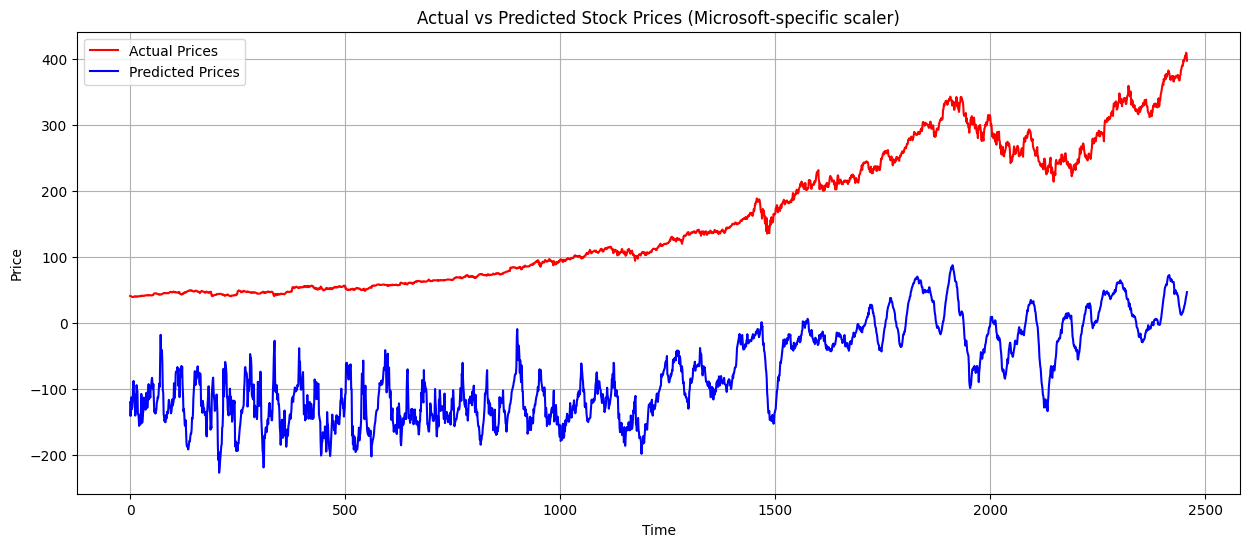

In [3]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define the model class (same as in your original code)
class StockPredictor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_encoder_layers=2, hidden_dim=64):
        super().__init__()
        
        # Input processing
        self.input_projection = nn.Linear(input_dim, d_model)
        self.input_norm = nn.LayerNorm(d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,  
            dropout=0.1,
            batch_first=True,
            activation=F.gelu
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # Single-layer LSTM
        self.lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=1,  
            batch_first=True,
            bidirectional=True
        )
        
        # Output processing
        self.output_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        # Input processing
        x = self.input_norm(self.input_projection(x))
        
        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        
        # Take the last timestep
        x = lstm_out[:, -1, :]
        x = self.output_norm(x)
        x = self.fc(x)
        
        return x

# Define the RSI calculation function
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Load the saved model and preprocessing parameters
def load_model_complete(path='stock_predictor_complete.pth'):
    checkpoint = torch.load(path)
    
    # Extract model parameters
    input_dim = checkpoint['input_dim']
    d_model = checkpoint['architecture']['d_model']
    nhead = checkpoint['architecture']['nhead']
    num_encoder_layers = checkpoint['architecture']['num_encoder_layers']
    hidden_dim = checkpoint['architecture']['hidden_dim']
    
    # Create and load model
    model = StockPredictor(
        input_dim=input_dim,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        hidden_dim=hidden_dim
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Load scaler and other preprocessing parameters
    scaler = checkpoint['scaler']
    selected_features = checkpoint['selected_features']
    sequence_length = checkpoint['sequence_length']
    
    return model, scaler, selected_features, sequence_length

# Load the model and preprocessing parameters, but we'll ignore the original scaler
model, original_scaler, selected_features, sequence_length = load_model_complete('stock_predictor_complete.pth')
print("Model loaded successfully!")
print(f"Selected features: {selected_features}")
print(f"Sequence length: {sequence_length}")

# Load test dataset
new_data = pd.read_csv('../datasets/msft.csv')
print(f"Test data loaded: {new_data.shape}")

# Reset index
new_data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = new_data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
new_data[numeric_data.columns] = new_data[numeric_data.columns].fillna(numeric_data.mean())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Same as in original
for ma in ma_day:
    column_name = f"MA for {ma} days"
    new_data[column_name] = new_data['Close'].rolling(window=ma).mean()

# Calculate Exponential Moving Average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    new_data[column_name] = new_data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
new_data['RSI_14'] = calculate_rsi(new_data['Close'])

# Drop NaN values
new_data.dropna(inplace=True)
print(f"Data after preprocessing: {new_data.shape}")

# Check if all required features are present
missing_features = [feature for feature in selected_features if feature not in new_data.columns]
if missing_features:
    print(f"Warning: Missing features in test dataset: {missing_features}")
else:
    print("All required features are present in the test dataset.")

# Select the same features as in the original model
test_features = new_data[selected_features]

# Create a Microsoft-specific scaler and fit it to the Microsoft data
msft_scaler = MinMaxScaler()
scaled_features = msft_scaler.fit_transform(test_features)

# Create sequences
X_test = []
y_test = []

for i in range(len(scaled_features) - sequence_length):
    X_test.append(scaled_features[i:(i + sequence_length)])
    y_test.append(scaled_features[i + sequence_length, 3])  # Using index 3 for Close price

X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.FloatTensor(np.array(y_test))
print(f"Prepared {len(X_test)} sequences for testing")

# Create DataLoader
batch_size = 128
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Make predictions
predictions = []
model.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

# Convert to numpy array and reshape
predictions = np.array(predictions).reshape(-1, 1)

# Create a full feature array with zeros
predictions_full = np.zeros((predictions.shape[0], len(selected_features)))

# Place predictions in the Close price position (index 3)
predictions_full[:, 3] = predictions.flatten()

# Important: Use the Microsoft-specific scaler for inverse transformation
predictions = msft_scaler.inverse_transform(predictions_full)[:, 3]

# Get actual Close prices using the Microsoft-specific scaler
actual_scaled = np.zeros((len(y_test), len(selected_features)))
actual_scaled[:, 3] = y_test.numpy()
actual_prices = msft_scaler.inverse_transform(actual_scaled)[:, 3]

# Calculate metrics
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Stock Prices (Microsoft-specific scaler)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()